In [ ]:
import requests
from fastdownload import download_url
from fastai.vision.all import show_image
from PIL import Image
from pathlib import Path
from fastai.vision.utils import download_images, verify_images, resize_images
from fastcore.all import L
from fastai.vision.all import * # type: ignore
from fastai.vision.widgets import *
PIXABAY_KEY = "52842263-9fb6f8c4b8e68fda8939d003f"

def search_pixabay(term, count=150, lang="en", image_type="photo"):
    """
    Search Pixabay for keyword images and return a FastAI-friendly list of URLs.
    """
    url = "https://pixabay.com/api/"
    params = {
        "key": PIXABAY_KEY,
        "q": term,
        "lang": lang,
        "image_type": image_type,
        "orientation": "all",
        "safesearch": "true",
        "order": "popular",
        "per_page": count
    }
    r = requests.get(url, params=params)
    if r.status_code != 200:
        print("Status:", r.status_code)
        print("Error:", r.text)
        r.raise_for_status()
    js = r.json()
    return L(item["largeImageURL"] for item in js.get("hits", []) if "largeImageURL" in item)

# 🔎 Example usage
results = search_pixabay("grizzly bear", count=150)
print(len(results), "images found")
print(results[:3])


d:\miniforge\envs\ml-nlp\Lib\site-packages\fastai\imports.py:26: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.4)
  import requests,yaml,matplotlib.pyplot as plt,pandas as pd,scipy


150 images found
['https://pixabay.com/get/ge15047f6ac2a5e81d680624df72ba823cc2fe6ae33be58eaed614472617234feba50fb4581ce358d05af7ca9e19a66d01e2c35c41e9fad6ae8cde5d0a911a2cf_1280.png', 'https://pixabay.com/get/g50165be24995b9d390a77bda35064eccc1cdfba09a80463172ee73df2bc1beca65c86f9c624a7d421027f520c9c5cbbc_1280.jpg', 'https://pixabay.com/get/g83cbc7acbc6b08f17db9ddb2a11c3906a606a314b31355360be424286e37fe3651366394163f2aed457ab29d297b644afbd51705faa4ff4afcfcb890a4c4b574_1280.jpg']


In [2]:
ims = results.attrgot('contentUrl')
len(ims)

150

In [3]:
ims = ['https://pixabay.com/get/g28e5a9700b9d6e13ebf2082d44b674dcd7c43cbe448e52706a473201d9272955edd765edf6786493ac3fd0b2da4865ac5af8975d208153550a835ffd2ad8fc43_1280.png']

In [4]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

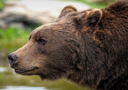

In [5]:
im = Image.open(dest)
im.to_thumb(128,128) # type: ignore

In [6]:
bear_types = 'grizzly', 'black','teddy'
path = Path('bears')

In [7]:
path.mkdir(parents=True, exist_ok=True)
for o in bear_types:
    dest = path/o
    dest.mkdir(exist_ok=True)
    results = search_pixabay(f'{o} bear', count=80)
    download_images(dest, urls=list(results))

In [8]:
fns = get_image_files(path)
fns

(#960) [Path('bears/black/00773862-1f28-436b-9aba-2765e18a3166.jpg'),Path('bears/black/014be23f-a1a0-476a-b647-bc5be897e6fc.jpg'),Path('bears/black/01c18ea3-8aaa-416a-bd78-303beba2b5ce.jpg'),Path('bears/black/01dbe6bd-4447-4114-a07c-928d945a9533.jpg'),Path('bears/black/021d1368-ce61-41f5-8f4e-7e43981f94b0.jpg'),Path('bears/black/03be11e3-c151-48ac-b11f-e7801121489f.jpg'),Path('bears/black/042fbe31-4890-4d12-9cd3-be62417bbc38.jpg'),Path('bears/black/04d84799-7f5a-46b2-aa5e-10f323012ace.jpg'),Path('bears/black/05265195-b441-4f43-9e9d-a01595783d9d.jpg'),Path('bears/black/07005732-dad8-42e4-b3fd-1d04ab08eebf.jpg'),Path('bears/black/0733877b-8c7c-43a4-a136-36331501017f.jpg'),Path('bears/black/075fd204-f991-4a73-b23a-d78953feac0d.jpg'),Path('bears/black/0778d2c8-f531-494c-910e-06ab107d2000.jpg'),Path('bears/black/07892682-d167-44d8-8ca3-416c30e373cb.jpg'),Path('bears/black/08bf2d32-200f-470e-ac00-25161f063584.jpg'),Path('bears/black/091437da-bd8f-47b4-a5eb-af7712f16f21.jpg'),Path('bears/blac

In [9]:
failed = verify_images(fns)
failed

(#0) []

In [10]:
failed.map(Path.unlink)

(#0) []

In [11]:
# Dataloaders are a thin calss that just stores what Objects you pass to it and makes them available as train and valid. 
class DataLoaders(GetAttr):
    def _init_(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train, valid = add_props(lambda i, self: self[i])

In [12]:
# First we provided a tuple where we specify what types we want for the independent and dependent variables: blocks = (ImageBlock, CategoryBlock)
# independent variables is what we are using to make predictions from and dependent variable is our target
from fastai.vision.all import *

bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128),
)

In [13]:
dls = bears.dataloaders(path)

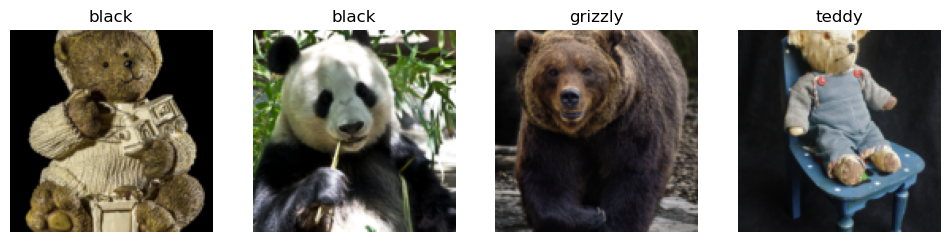

In [14]:
dls.valid.show_batch(max_n=4, nrows=1)

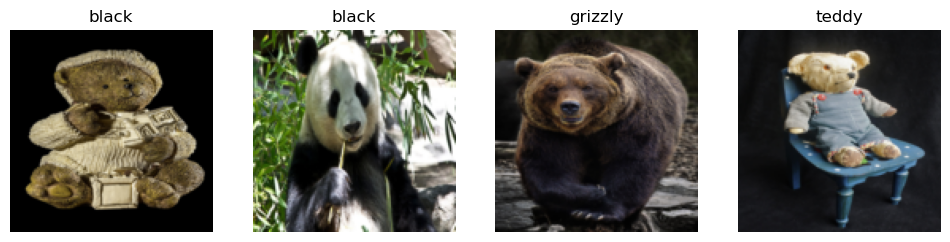

In [16]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)


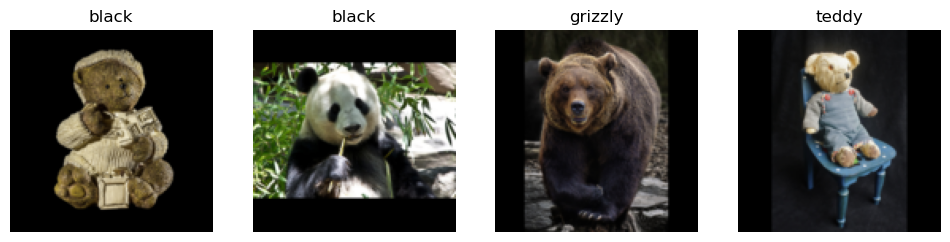

In [18]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

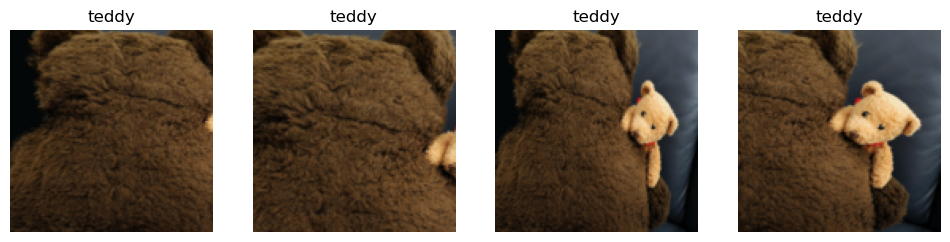

In [19]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

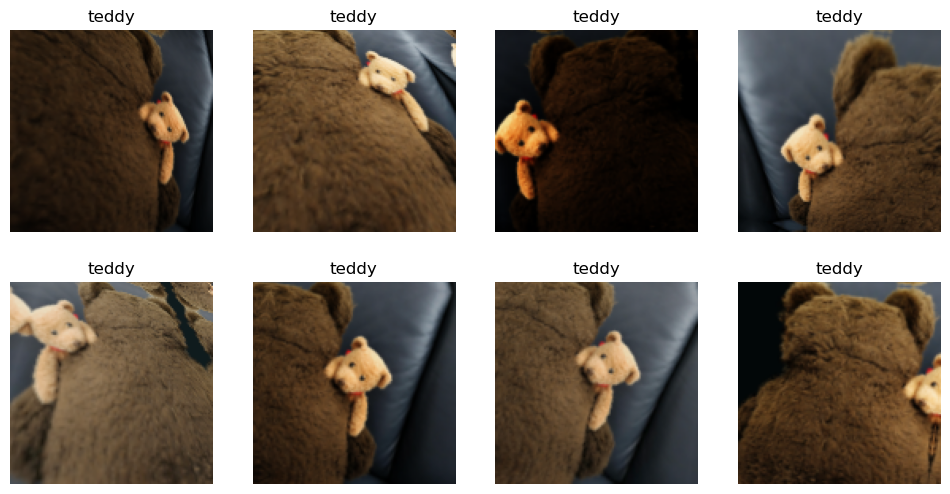

In [21]:
# Data augmentation can refer to creating random variations of our input data so they appear different. I.e image rotation, flipping, perspective warping, brightness changes and contrast changes
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [22]:
# Training our model and using to clena the data
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [23]:
# create our Learner and fine-tune it
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.046170,0.454512,0.098958,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.355028,0.121159,0.041667,00:09
1,0.243693,0.039061,0.020833,00:09
2,0.165888,0.037954,0.020833,00:09
3,0.128999,0.035835,0.015625,00:09


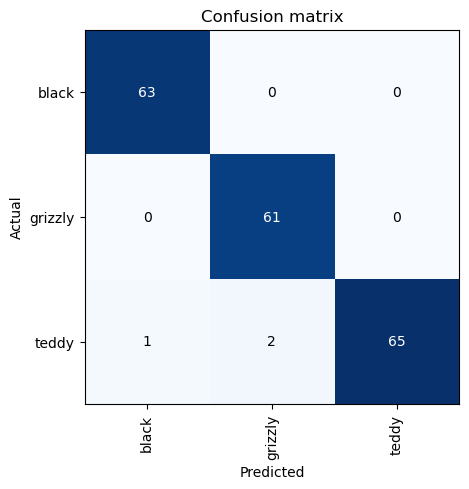

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

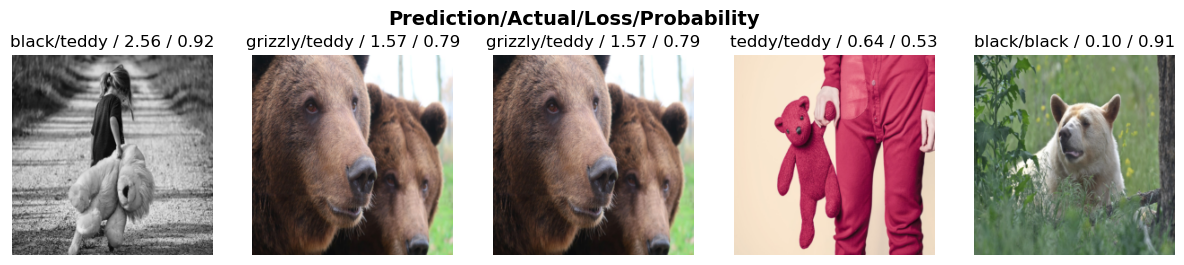

In [25]:
interp.plot_top_losses(5, nrows=1)

In [26]:
cleaner = ImageClassifierCleaner(learn)
clear

NameError: name 'ImageClassifierCleaner' is not defined